# 초기설정

In [6]:
%pip install moviepy jiwer matplotlib pandas openai-whisper
%pip install --upgrade google-cloud-speech
%pip install python-dotenv
%pip install boto3
%pip install azure-cognitiveservices-speech
%pip install pydub
%pip install -U openai-whisper
%pip install yt-dlp
%pip install google-cloud-storage
%pip install SoundFile

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# 라이브러리 import

In [ ]:
import os
from dotenv import load_dotenv
import time
import wave
from moviepy import VideoFileClip
import jiwer
import matplotlib.pyplot as plt
import pandas as pd
import requests
from pydub import AudioSegment
import json
from IPython.display import display
import re
from concurrent.futures import ProcessPoolExecutor, as_completed
import cudf
import glob
import soundfile as sf
from IPython.display import display
import argparse
import torch

# STT 라이브러리 설치
from google.cloud import speech # google
import whisper # whisper
import boto3
from botocore.client import Config
import uuid
import azure.cognitiveservices.speech as speechsdk
import whisper

from google.cloud import storage

# 데이터 선언

In [8]:
load_dotenv()

True

In [9]:
service_costs = {
    "CLOVA": 0.01,      # 네이버 CLOVA: 기본 모드 예시 (15초당 약 0.01)
    "Whisper": 0,   # OpenAI Whisper API 사용 시: 약 0.006 (분당 비용 예시)
    "Google STT": 0.006,  # Google STT: 기본 모드 시 약 0.006
    "AWS": 0.0075,      # AWS Transcribe: 기본 모드 시 약 0.0075
    "Azure": 0.01,      # Microsoft Azure Speech: 기본 모드 시 약 0.01
}

customization_capability = {
    "CLOVA": False,     # 네이버 CLOVA: 기본 모델만 제공되어 커스터마이징 지원 안 함
    "Whisper": False,   # Whisper: 공식 커스터마이징 지원 없음 (오픈소스 모델이라 직접 파인튜닝은 가능하나 별도 지원 미제공)
    "Google STT": True, # Google STT: phrase hints 등 제한적 커스터마이징 지원
    "AWS": True,        # AWS Transcribe: Custom Vocabulary 및 Custom Language Model 지원
    "Azure": True,      # Azure Speech: Custom Speech 기능 등으로 커스터마이징 지원
}

speaker_classification = {
    "CLOVA": False,
    "Whisper": False,   
    "Google STT": True, 
    "AWS": True,        
    "Azure": True, 
}


In [ ]:
# # 사전 준비
# print("🔧 Whisper 모델 로딩...")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# whisper_model = whisper.load_model("medium", device=device)

# print("🔧 Google STT 클라이언트 초기화...")
# google_client = speech.SpeechClient()

# print("🔧 AWS 클라이언트 초기화...")
# aws_client = boto3.client('transcribe',
#                           region_name='us-west-2',
#                           aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
#                           aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"))

# print("🔧 Azure STT 설정 초기화...")
# azure_config = speechsdk.SpeechConfig(
#     subscription=os.getenv("AZURE_SPEECH_KEY"),
#     region=os.getenv("AZURE_SPEECH_REGION")
# )

# 필요함수

## WER 계산 함수

In [10]:
# WER 계산 함수 (jiwer 라이브러리 사용)
def calculate_wer(reference, hypothesis):
    # 텍스트를 소문자로 변환, 문장부호 제거, 양쪽 공백 제거 등을 적용하여 비교
    transformation = jiwer.Compose([
        jiwer.ToLowerCase(), 
        jiwer.RemovePunctuation(), 
        jiwer.Strip(),
        jiwer.ReduceToListOfListOfWords()
    ])
    wer = jiwer.wer(reference, hypothesis, truth_transform=transformation,
                    hypothesis_transform=transformation)
    return wer

In [11]:
# 도움 함수: 오디오 길이(초) 반환 (wave 모듈 활용)
def get_audio_duration(audio_path):
    with wave.open(audio_path, 'rb') as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
    return duration
    # audio = AudioSegment.from_file(audio_path, format="mp3")
    # return len(audio) / 1000.0  # milliseconds to seconds

## script 전처리 함수

In [ ]:
# # cudf.Series.str.replace 에서 regex=True 로 동작
# RE_DUAL = r'\(([^)]+)\)/\([^)]+\)'
# RE_MENTION = r'@([가-힣]+)\d*'
# RE_SLASH = r'/\(([^)]+)\)'
# RE_PARENS = r'[\(\)]'
# RE_SPEAKER = r'\b\d+:\s*'
# RE_SPACE = r'\s+'


# def gpu_clean_series(s: cudf.Series) -> cudf.Series:
#     s = s.str.replace(RE_DUAL,    r'\1', regex=True)
#     s = s.str.replace(RE_MENTION, r'\1', regex=True)
#     s = s.str.replace(RE_SLASH,   r'',   regex=True)
#     s = s.str.replace(RE_PARENS,  r'',   regex=True)
#     s = s.str.replace(RE_SPEAKER, r'',   regex=True)
#     s = s.str.replace(RE_SPACE,   r' ',  regex=True)
#     return s.str.strip()


# stt 호출

In [ ]:
# # STT 시스템 API 호출 (각 함수 내에서 실제 API 연동 코드로 대체할 것)
# def stt_clova(audio_path: str):
#     """
#     Clova Speech Upload Recognition을 requests만으로 실행하는 함수

#     """
#     api_url = os.getenv("CLOVA_CLIENT_URL")
#     api_key = os.getenv("CLOVA_CLIENT_SECRET")

#     URL = f'{api_url}/recognizer/upload'

#     params = {
#         "language": "ko-KR",
#         "completion": "sync",
#         "callback": "",
#         "fullText": True,
#         "diarization": {"enable": True}
#     }

#     with open(audio_path, "rb") as audio_file:
#         files = {
#             "media": ("media", audio_file, "application/octet-stream"),
#             "params": (None, json.dumps(params), "application/json")
#         }
#         response = requests.post(
#             URL,
#             files=files,
#             headers={
#                 "X-CLOVASPEECH-API-KEY": api_key
#             },
#             timeout=60
#         )
#     response.raise_for_status()

#     result = response.json()

#     if response.status_code == 200:
#         print(result)
#         transcript = result["text"]
#         return transcript
#     else:
#         print(f"API 요청 실패 (상태 코드 {response.status_code}):", response.text)
#         return f"API 요청 실패 (상태 코드 {response.status_code}): {response.text}"


# def stt_whisper(audio_path):
#     # 2) 오디오 파일을 모델에 전달하여 transcription 수행
#     result = whisper_model.transcribe(audio_path, language="ko")

#     # 3) 텍스트 결과 추출
#     transcript = result.get("text", "").strip()

#     return transcript


# def stt_google(audio_path: str):
#     # ✅ GCS 업로드 설정
#     bucket_name = "ondam_storage"
#     destination_blob_name = f"stt_test/{os.path.basename(audio_path)}"
#     blob_uri = f"gs://{bucket_name}/{destination_blob_name}"

#     # ✅ GCS 업로드
#     storage_client = storage.Client()
#     bucket = storage_client.bucket(bucket_name)
#     blob = bucket.blob(destination_blob_name)
#     blob.upload_from_filename(audio_path)
#     print(f"✅ GCS 업로드 완료: {blob_uri}")

#     # ✅ STT 요청
#     audio = speech.RecognitionAudio(uri=blob_uri)
#     config = speech.RecognitionConfig(
#         encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
#         language_code="ko-KR",
#     )

#     transcript = ""
#     try:
#         operation = speech.SpeechClient().long_running_recognize(config=config, audio=audio)
#         response = operation.result(timeout=3600)
#         transcript = " ".join([res.alternatives[0].transcript for res in response.results])
#     except Exception as e:
#         print("❌ Google STT 오류:", e)

#     return transcript



# def stt_aws(audio_path: str):
#     region = "us-west-2"
#     s3_bucket = "stt-test1324"
#     s3_key = f"stt_test/{os.path.basename(audio_path)}"
#     s3_uri = f"https://{s3_bucket}.s3.{region}.amazonaws.com/{s3_key}"

#     # ✅ S3 업로드
#     s3 = boto3.client('s3',
#                       aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
#                       aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"))
#     s3.upload_file(audio_path, s3_bucket, s3_key)
#     print(f"✅ S3 업로드 완료: {s3_uri}")

#     transcribe = boto3.client('transcribe',
#                               region_name=region,
#                               aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
#                               aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"))

#     job_name = f"transcription-job-{uuid.uuid4()}"
#     transcribe.start_transcription_job(
#         TranscriptionJobName=job_name,
#         Media={'MediaFileUri': s3_uri},
#         MediaFormat="wav",
#         LanguageCode="ko-KR"
#     )

#     while True:
#         status = transcribe.get_transcription_job(TranscriptionJobName=job_name)
#         job_status = status['TranscriptionJob']['TranscriptionJobStatus']
#         print(f"현재 Job 상태: {job_status}")
#         if job_status in ['COMPLETED', 'FAILED']:
#             break
#         time.sleep(10)

#     transcript = ""
#     if job_status == 'COMPLETED':
#         transcript_uri = status['TranscriptionJob']['Transcript']['TranscriptFileUri']
#         r = requests.get(transcript_uri)
#         result_json = r.json()
#         transcript = result_json.get('results', {}).get('transcripts', [{}])[0].get('transcript', '')
#     else:
#         transcript = "Transcription failed"

#     return transcript



# def stt_azure(audio_path):
#     # Azure Speech 서비스 구독 키와 리전 설정 (환경 변수로 관리하는 것을 권장)
#     subscription_key = os.getenv("AZURE_SPEECH_KEY")
#     region = os.getenv("AZURE_SPEECH_REGION")

#     # Speech 구성 생성
#     speech_config = speechsdk.SpeechConfig(subscription=subscription_key, region=region)
#     speech_config.speech_recognition_language = "ko-KR"  # 인식 언어 설정


#     # 오디오 파일 로컬 경로에서 AudioConfig 생성
#     audio_config = speechsdk.audio.AudioConfig(filename=audio_path)

#     # SpeechRecognizer 생성: 음성 인식을 위한 구성 및 오디오 입력 설정
#     recognizer = speechsdk.SpeechRecognizer(speech_config=speech_config, audio_config=audio_config)

#     # 결과 누적할 리스트와 플래그
#     transcripts = []
#     done = False

#     # 세션이 끝나면 done=True
#     def stop_cb(evt):
#         nonlocal done
#         done = True

#     # 인식된 부분이 나올 때마다 append
#     recognizer.recognized.connect(
#         lambda evt: transcripts.append(evt.result.text))
#     # 에러나 세션 종료 이벤트 구독
#     recognizer.session_stopped.connect(stop_cb)
#     recognizer.canceled.connect(stop_cb)
#     # 스트리밍 인식 시작
#     recognizer.start_continuous_recognition()
#     timeout = 1200
#     while not done:
#         # elapsed = time.time() - start
#         # if elapsed > timeout:
#         #     print(f"⚠️ 타임아웃({timeout}s) 도달, 인식 중단합니다.")
#         #     recognizer.stop_continuous_recognition()
#         #     break
#         time.sleep(0.5)
#     recognizer.stop_continuous_recognition()

#     # 전체 텍스트 합치기
#     transcript = " ".join(transcripts).strip()

#     print("Full transcript:", transcript)
#     return transcript

# wer 검증 로직

In [ ]:
# STT_FUNCTIONS = {
#     "CLOVA":      stt_clova,
#     "Whisper":    stt_whisper,
#     "Google STT": stt_google,
#     "AWS":        stt_aws,
#     "Azure":      stt_azure
# }

# 메인 함수


In [28]:
%load_ext autoreload
%autoreload 2
from stt_utils import process_one_gpu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def main_gpu(root_audio_dir, root_script_dir, engines, workers=None):
    results = []

    # 1) 분야별(도메인별) 서브폴더 리스트
    domains = [
        d for d in os.listdir(root_script_dir)
        if os.path.isdir(os.path.join(root_script_dir, d))
    ]

    with ProcessPoolExecutor(max_workers=workers) as exe:
        futures = []
        # 2) 각 도메인별 폴더를 돌면서
        for domain in domains:
            script_dir = os.path.join(root_script_dir, domain)
            audio_dir = os.path.join(root_audio_dir,  domain)

            # 3) 이 폴더 안의 모든 .txt 파일 이름(basename) 추출
            basenames = [
                os.path.splitext(os.path.basename(p))[0]
                for p in glob.glob(os.path.join(script_dir, '*.txt'))
            ]

            # 4) 파일 × 엔진 조합으로 process_one_gpu 실행 스케줄링
            for b in basenames:
                for eng in engines:
                    print("SUBMIT", domain, b, eng)
                    futures.append(
                        exe.submit(
                            process_one_gpu,
                            audio_dir, script_dir, b, eng
                        )
                    )

        # 5) 결과 수집
        for fut in as_completed(futures):
            try:
                results.append(fut.result())
            except Exception as e:
                print("Error:", e)

    # 6) cudf DataFrame + 집계
    gdf = cudf.DataFrame(results)
    pdf = gdf.to_pandas()
    summary = pdf.groupby(['domain', 'engine']).agg({
        'basename':      'count',
        'wer':           'mean',
        'cost_usd':      'sum',
        'stt_time_sec':  'mean'
    }).reset_index().rename(columns={'basename': 'total_files'})

    # 7) CSV 저장
    summary.to_csv('gpu_summary.csv', index=False)
    print("? gpu_summary.csv 저장 완료")

    # 8) 파일별 전사결과도 별도 CSV로
    transcripts = pdf[['basename', 'engine', 'transcript']]
    transcripts.to_pandas().to_csv(
        'stt_transcripts.csv', index=False, encoding='utf-8-sig'
    )
    print("? stt_transcripts.csv 저장 완료")

    # 9) 화면에 테이블·차트 띄우기
    # pdf = gdf.to_pandas()
    display(pdf)

    def draw_bar(x, y, title, ylabel):
        plt.figure()
        plt.bar(x, y)
        plt.title(title)
        plt.ylabel(ylabel)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # 도메인별 차트
    for eng in pdf['engine'].unique():
        sub = pdf[pdf['engine'] == eng]
        draw_bar(sub['domain'], sub['stt_time_sec'],
                 f"{eng} 평균 걸린 시간(초)", "평균 시간(초)")
        draw_bar(sub['domain'], sub['wer'],
                 f"{eng} 평균 WER", "WER")
        draw_bar(sub['domain'], sub['cost_usd'],
                 f"{eng} 총 비용", "원")

    # 엔진별 전체 집계
    summary_engine = gdf.groupby('engine').agg({
        'stt_time_sec': 'mean',
        'wer':          'mean',
        'cost_usd':     'sum'
    }).reset_index().rename(columns={
        'stt_time_sec':   'avg_stt_time_sec',
        'wer':            'avg_wer',
        'cost_usd':       'total_cost_usd'
    })

    draw_bar(summary_engine['engine'], summary_engine['avg_stt_time_sec'],
             "엔진별 평균 STT 호출 시간(초)", "평균 시간(초)")
    draw_bar(summary_engine['engine'], summary_engine['avg_wer'],
             "엔진별 평균 WER", "WER")
    draw_bar(summary_engine['engine'], summary_engine['total_cost_usd'],
             "엔진별 총 비용", "원")

# 실행

In [30]:
import multiprocessing as mp
mp.set_start_method('spawn', force=True)

In [ ]:
# 사전 준비
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
whisper_model = whisper.load_model("medium", device=device)

print("🔧 Google STT 클라이언트 초기화...")
google_client = speech.SpeechClient()

print("🔧 AWS 클라이언트 초기화...")
aws_client = boto3.client('transcribe',
                          region_name='us-west-2',
                          aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
                          aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"))

print("🔧 Azure STT 설정 초기화...")
azure_config = speechsdk.SpeechConfig(
    subscription=os.getenv("AZURE_SPEECH_KEY"),
    region=os.getenv("AZURE_SPEECH_REGION")
)


🔧 Whisper 모델 로딩...
🔧 Google STT 클라이언트 초기화...
🔧 AWS 클라이언트 초기화...
🔧 Azure STT 설정 초기화...


In [ ]:
root_audio_dir = './VS1/data'
root_script_dir = './VS1/data'
engines = [
    "CLOVA", 
    "Whisper", 
    "Google STT", 
    "AWS", 
    "Azure",
]
worker = None


if __name__=='__main__':
    import multiprocessing
    multiprocessing.set_start_method('spawn', force=True)
    main_gpu(root_audio_dir, root_script_dir, engines, worker)

SUBMIT 경제 SRBAB21000001 Whisper
SUBMIT 경제 SRBAB21000002 Whisper
SUBMIT 경제 SRBAB21000003 Whisper
SUBMIT 경제 SRBAB21000004 Whisper
SUBMIT 경제 SRBAB21000005 Whisper
SUBMIT 경제 SRBAB21000006 Whisper
SUBMIT 경제 SRBAB21000007 Whisper


SUBMIT 경제 SRBAB21000008 Whisper
SUBMIT 경제 SRBAB21000009 Whisper
SUBMIT 경제 SRBAB21000010 Whisper
SUBMIT 경제 SRBBB21000001 Whisper
SUBMIT 경제 SRBBB21000002 Whisper
SUBMIT 경제 SRBBB21000003 Whisper
SUBMIT 경제 SRBBB21000004 Whisper
SUBMIT 경제 SRBBB21000005 Whisper
SUBMIT 경제 SRBBB21000006 Whisper
SUBMIT 경제 SRBBB21000007 Whisper
SUBMIT 경제 SRBBB21000008 Whisper
SUBMIT 경제 SRBBB21000009 Whisper
SUBMIT 경제 SRBBB21000010 Whisper
SUBMIT 교육 DGBED21000001 Whisper
SUBMIT 교육 DGBED21000002 Whisper
SUBMIT 교육 DGBED21000003 Whisper
SUBMIT 교육 DGBED21000004 Whisper
SUBMIT 교육 DGBED21000005 Whisper
SUBMIT 교육 DGBED21000006 Whisper
SUBMIT 교육 DGBED21000007 Whisper
SUBMIT 교육 DGBED21000008 Whisper
SUBMIT 교육 DGBED21000009 Whisper
SUBMIT 교육 DGBED21000010 Whisper
SUBMIT 교육 DGBED21000011 Whisper
SUBMIT 교육 DGBED21000012 Whisper
SUBMIT 교육 DGBED21000013 Whisper
SUBMIT 교육 DGBED21000014 Whisper
SUBMIT 교육 SRBAD21000001 Whisper
SUBMIT 교육 SRBAD21000002 Whisper
SUBMIT 교육 SRBAD21000003 Whisper
SUBMIT 교육 SRBBD21000001 Whisper
SUBMIT 교

KeyError: 'domain'


📥 [1] URL 처리 중: https://www.youtube.com/watch?v=TjZ0jgL-20Y
🎬 yt-dlp 다운로드 시작... → ./video/yt_audio_9aeae2b2.%(ext)s
✅ 다운로드 완료: ./video/yt_audio_9aeae2b2.webm
🎧 ffmpeg 변환 시작 → ./audio/audio1.wav
✅ WAV 저장 완료: ./audio/audio1.wav
✅ 저장 완료: ./audio/audio1.wav

📥 [2] URL 처리 중: https://www.youtube.com/watch?v=IdiNw-2oOMM
🎬 yt-dlp 다운로드 시작... → ./video/yt_audio_8e8a4cf3.%(ext)s
✅ 다운로드 완료: ./video/yt_audio_8e8a4cf3.webm
🎧 ffmpeg 변환 시작 → ./audio/audio2.wav
✅ WAV 저장 완료: ./audio/audio2.wav
✅ 저장 완료: ./audio/audio2.wav

📥 [3] URL 처리 중: https://www.youtube.com/watch?v=VoEz0Ze8Dbk
🎬 yt-dlp 다운로드 시작... → ./video/yt_audio_78f28fb6.%(ext)s
✅ 다운로드 완료: ./video/yt_audio_78f28fb6.webm
🎧 ffmpeg 변환 시작 → ./audio/audio3.wav
✅ WAV 저장 완료: ./audio/audio3.wav
✅ 저장 완료: ./audio/audio3.wav

📥 [4] URL 처리 중: https://www.youtube.com/watch?v=J5804SZYKCQ
🎬 yt-dlp 다운로드 시작... → ./video/yt_audio_d7a60f5e.%(ext)s
✅ 다운로드 완료: ./video/yt_audio_d7a60f5e.webm
🎧 ffmpeg 변환 시작 → ./audio/audio4.wav
✅ WAV 저장 완료: ./audio/audio4.wav
✅ 저장 완료:

/Users/jeongminchoi/miniconda3/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


🧪 Google STT 실행 중...
✅ GCS 업로드 완료: gs://ondam_storage/stt_test/audio1.wav
🧪 AWS 실행 중...
✅ S3 업로드 완료: https://stt-test1324.s3.us-west-2.amazonaws.com/stt_test/audio1.wav
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: COMPLETED
🧪 Azure 실행 중...
Full transcript: 연휴 마지막날 도심의 놀이공원에 가족단위 나들이객들이 북적이고 있습니다. 현장에 YTN 이슈 리포터가 나가 있는데요. 서지연 리포터. 네 서울 롯데월드에 나와 있습니다. 오늘 날씨까지 좋아서 나들이객이 더 많겠군요? 네, 그렇습니다. 지금 이곳은 시간이 지날수록 방문객들이 늘어 발 디딜 틈없이 북적이고 있는데요. 귀여운 머리띠를 한 학생들부터 어린이날을 미처 즐기지 못했던 가족들까지 정말 많은 분들이 이곳을 찾고 있습니다. 그럼 오늘 이곳을 찾은 가족들의 이야기를 들어보겠습니다. 애기가 많이 아파가지고 병원에 있었는데 다행히 어제 퇴원을 하게 돼서 이렇게 오늘 왔는데 오늘 날씨도 좋고 즐거운 시간 보낼 수 있을 것 같아서 너무 기분이 좋습니다. 대체 공휴일이 있어서 조금 더 가족들이랑 시간 보낼 수 있고 또 아기랑도 시간을 좀 더 만들 수 있어서 좋은 추억 만들 수 있을 것 같습니다. 이 곳은 스릴 넘치는 놀이기구를 즐기는 시민들의 함성 소리와 아이들의 웃음소리로 가득한데요. 롤러코스터와 수직 낙하 기구 같은 인기 놀이기구 앞은 끝이 보이지 않는 긴 줄이 늘어섰습니다. 5월 가정의 달을 맞아 다양한 체험과 특별 전시회도 마련됐는데요. 오는 25일까지 놀이공원 전역에서는 오랜 시간 사랑받은 인기 캐릭터들과 함께 하는 축제가 이어져 남녀노소 모두에게 특별한 추억을 선사합니다. 또 새롭게 정비된 퍼레이드에는 관람

/Users/jeongminchoi/miniconda3/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


🧪 Google STT 실행 중...
✅ GCS 업로드 완료: gs://ondam_storage/stt_test/audio2.wav
🧪 AWS 실행 중...
✅ S3 업로드 완료: https://stt-test1324.s3.us-west-2.amazonaws.com/stt_test/audio2.wav
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: COMPLETED
🧪 Azure 실행 중...
Full transcript: 구글 인공지능 조직인 구글 딥마인드 최고경영자 데미스 허사비스는 인간과 같은 수준의 AI 가 향후 오년에서 10년 안에 등장할 것이라고 전망했습니다. 지난해 노벨 화학상 수상자인 허사비스 CEO 는 런던 구글 딥마인드 본사에서 열린 미디어브리핑에서 향후 오년에서 10년 안에 많은 AI 기능이 전면에 등장하고 우리가 범용 인공지능 AGI 라고 부르는 단계로 나아갈 것으로 생각한다고 밝혔습니다. 또 AGI 를 인간이 할 수 있는 모든 복잡한 능력을 보여줄 수 있는 시스템으로 정의하며, 현재 AI 시스템은 수동적이고 아직 할 수 없는 것들이 많아지지. 단계에 도달하지 못했다고 평가했습니다. 이어 인간을 뛰어넘는 AI 를 인공지능, 초지능 as i 라 지칭하며 asi 는 agi 이후에 등장하며 인간의 지능을 초월할 것으로 예상된다. 그런 획기적인 일 이 언제 일어날지는 아무도 모른다고 덧붙였습니다. A gi 등장에 대한 허 서비스 CEO 의 이런 언급은 다른 주요 인물들의 전망보다 다소 늦은 것입니다. 테슬라. 테슬라 CEO 일론 머스크는 지난해 AGI 가 2026년까지 가능할 것이라고 했고, 채찍 피티 개발사 오픈 AICEO 샘 올트먼은 비교적 가까운 미래에 개발될 것이라고 전망했습니다. 또 오픈 AI 대항마로 평가받는 AI 스타트업 엔스 로픽 CEO 다리오 아모데이는 향후 이 년에서 3년 안에 거의 모든 작업에

/Users/jeongminchoi/miniconda3/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


🧪 Google STT 실행 중...
✅ GCS 업로드 완료: gs://ondam_storage/stt_test/audio3.wav
🧪 AWS 실행 중...
✅ S3 업로드 완료: https://stt-test1324.s3.us-west-2.amazonaws.com/stt_test/audio3.wav
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: COMPLETED
🧪 Azure 실행 중...
Full transcript: 사월에 코앞에 두고도 꽃샘추위의 쌀쌀함이 감돌고 있습니다. 오늘 저녁까지는 내륙의 약한 빗방울과 눈발이 흩날려 더 춥게 느껴지겠는데요. 내일도 곳곳에선 아침에 영하권이 보이겠고, 일교차가 십오도 이상 크게 나겠습니다. 한편 내일 낮부터는 온화한 서풍이 불어오기 시작하면서 대기가 더욱 메말라가겠습니다. 현재도 대부분 지역에 건조 주의보가 발효 중입니다. 추가 화재 사고가 일어나지 않도록 계속해서 신경 써 주셔야겠습니다. 내일 전국 하늘에는 구름 많이 지나겠고 바람도 강하게 불겠습니다. 초속 십오에서 20m 안팎의 돌풍이 불어 시설물 점검을 잘 해주셔야겠습니다. 아침까지는 예년 이맘때보다 기온이 낮겠습니다. 서울이 일도 춘천은 영하 삼도, 대전과 전주 영도 보이겠습니다. 낮부터는 기온이 오름세를 보이겠습니다. 서울이 십삼도 광주 십사도, 대구는 십오도까지 오르겠습니다. 3월 늦깎이 추위는 점점 물러나겠고요, 화요일부터 기온이 평년 수준으로 회복되겠습니다. 날씨였습니다.

🔍 [audio4] STT 평가 시작
🧪 CLOVA 실행 중...
{'result': 'COMPLETED', 'message': 'Succeeded', 'token': '33cbf97974a942f6b764eac550ca3a78', 'version': 'ncp_v2_v2.3.8-22e1a5c-20241203_240905-28192935-dirt

/Users/jeongminchoi/miniconda3/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


🧪 Google STT 실행 중...
✅ GCS 업로드 완료: gs://ondam_storage/stt_test/audio4.wav
🧪 AWS 실행 중...
✅ S3 업로드 완료: https://stt-test1324.s3.us-west-2.amazonaws.com/stt_test/audio4.wav
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: COMPLETED
🧪 Azure 실행 중...
Full transcript: 경기도 고양시의 한 중학교입니다. 자유학기제인 일학년을 대상으로 금융수업이 한창입니다. 환율이 오르면 왜 과자값이 오르는지 배우고. 굳이 그 기름 우리 수입하는데 돈을 빌리는데 신용이 중요한 이유를 깨닫습니다. 오늘 처음 알았어요 아 진짜 신용 점수를 오늘 처음 알아가지고 당장 필요한 용돈 관리법은 금융감독원이 개발한 장보기 게임을 통해 배웁니다. 좀 싼 거 사야 되는 거 아니야? 맞아요. 지금 돈이 7200 원 밖에 없어요. 미래 자산의 규모를 좌우하는 만큼 금융 개념은 어릴 때 정립하는 게 중요합니다. 하지만 중학교에선 사회과목 일부 단원의 경제가 있지만 금융 관련 내용은 비중이 적습니다. 고등학교에서도 입시 위주의 교육이 이뤄지다 보니 경제를 수능 선택과목으로 고르는 비중은 채 이퍼센트가 되지 않습니다. 그 결과 국내 고등학생의 금융 이해력은 백점 만점에 사십육점팔점 낙제 수준입니다. 가르칠 기회가 적어 교사들도 어떤 자료로 어떻게 금융을 가르쳐야 할지 난감할 때가 많습니다. 온라인 연수나 관련된 홈페이지 들어가서 조금 많이 연습은 하긴 하지만 그래도 아직은 미흡한 부분이 많습니다. 2008년 금융위기 이후 금융 문맹을 없애기 위해 해외에선 정규 교육과정에 금융 수업을 늘리고 있습니다. 누구나 퇴직을 하고 나면 근로 소득이 영이 되잖아요. 금융 소득이 나오게 만들어 놔야 되는 거고 그렇게 하려면? 이것

/Users/jeongminchoi/miniconda3/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


🧪 Google STT 실행 중...
✅ GCS 업로드 완료: gs://ondam_storage/stt_test/audio5.wav
🧪 AWS 실행 중...
✅ S3 업로드 완료: https://stt-test1324.s3.us-west-2.amazonaws.com/stt_test/audio5.wav
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: COMPLETED
🧪 Azure 실행 중...
Full transcript: 모든 물질은 아주 작은 원자들로 이루어져 있고, 양자역학은 그런 미시세계를 다루는 학문이에요. 그런데 이 원자의 크기가 너무나 작아서 이 세계에서는 이상한 일 이 발생합니다. 양자 중첩 현상 쉽게 비유하자면 무언가 있기도 하고 없기도 하다. 그러니까 이 상태가 동시에 있다. 뭘 계속 양자 얽힘 현상, 즉 양자 길인 정말 아무리 멀리 떨어져 있어도 즉시 서로 영향을 주고받을 수 있다, 이런 것들이 있어요. 왕자 컴퓨터 회사 아이용 표창업자이시자 양자 기술의 세계적 권위자이신. 김정상 교수님의 말을 빌려보겠습니다. 그게 왜 그런지는 알 수 없습니다. 자연이 그냥 그렇게 되어있는 거니깐요. 오 오.

🔍 [audio6] STT 평가 시작
🧪 CLOVA 실행 중...
{'result': 'COMPLETED', 'message': 'Succeeded', 'token': '3ad1d5445d2b4dd98ba7e93528d49486', 'version': 'ncp_v2_v2.3.8-22e1a5c-20241203_240905-28192935-dirty_v4.2.12_ko_firedepartment_20240624_', 'params': {'service': 'ncp', 'domain': 'general', 'lang': 'ko', 'comp

/Users/jeongminchoi/miniconda3/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


🧪 Google STT 실행 중...
✅ GCS 업로드 완료: gs://ondam_storage/stt_test/audio6.wav
🧪 AWS 실행 중...
✅ S3 업로드 완료: https://stt-test1324.s3.us-west-2.amazonaws.com/stt_test/audio6.wav
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: COMPLETED
🧪 Azure 실행 중...
Full transcript: 다음 소식입니다. 인공지능 기술이 어디까지 발전할지, 그 속도가 무서울 정도로 빠른데요. 이젠 머리속에 떠오른 내용을 글로 입력하면 이를 영상으로 만들어주는 기술까지 등장했습니다. 홍영재 기자가 보도합니다. 벚꽃이 핀 일본 도쿄 상영과 눈이 쌓인 길 위로 행인들이 걸음을 재촉합니다. 고양이 한 마리가 얼른 아침을 먹으라는 듯 더 자고 싶어하는 주인을 깨이고 있습니다. 카메라로 촬영한 듯한 이 장면들 사실 가짜입니다. 상황을 묘사하는 문장만 보고 영상 생성 인공지능이 만들어 낸 겁니다. 불과 1년 전 다른 AI 프로그램이 만들어낸 영상과 비교하면 이번에 오픈 AI 가 공개한 소라의 기술 수준을 알 수 있습니다. 영상 제작 등 관련 업계에선 놀랍다는 반응이 쏟아졌습니다. 네, 저도 보고 이거 직접 촬영을 한 것 같다라는 생각이 들 정도로 나와가지고 경력이 조금 있는 연출가들이라면은 그들이 어떻게 연출할지 에 대한 가이드를 또 받을 수 있을 것 같다라는 의견. 실제 같은 영상 제작의 비결 중 하나는 이 인공지능이 움직이는 물리적 세상을 학습하고 있기 때문입니다. 도쿄 교회를 달리는 기차에 창밖으로 보이는 풍경이라는 명령을 받고 만들어 낸 영상입니다. 창문 밖에 어두워지면 열차 내부의 승객이 유리창에 반사돼 보이는 기본적인 유리 법칙을 구현해 냈습니다. 인터넷 세상을 벗어난 데이터들과 벗어난 그 물리 세상에 그런 

/Users/jeongminchoi/miniconda3/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


🧪 Google STT 실행 중...
✅ GCS 업로드 완료: gs://ondam_storage/stt_test/audio7.wav
🧪 AWS 실행 중...
✅ S3 업로드 완료: https://stt-test1324.s3.us-west-2.amazonaws.com/stt_test/audio7.wav
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: COMPLETED
🧪 Azure 실행 중...
Full transcript: 네 대전 초등학생 피살 사건 이후 정부가 일본 학교 안전 대책을 내놓았는데요. 대면 인계 동행 귀가 원칙을 강화하는 게 핵심입니다. 소수의 강사가 학생들의 귀가 시간을 112 챙겨야 하다보니 업무과중을 호소하는 목소리가 나옵니다 김예림 기자입니다. 늘봄학교 수업이 끝날 무렵 교문 앞은 자녀를 마중 나온 학부모들로 북적입니다. 학생들을 줄지어 데리고 나온 강사들은 부모들을 만나. 지난달 대전 초등생 피살 사건 이후 정부는 초등학교 저학년을 대상으로 이런 대면인계 귀가 원칙을 강화했습니다. 학부모들은 일단 강화된 안전조치를 환영하는 분위기입니다. 다만 약속 시간을 마쳐야 하는 부담이 생겼습니다. 어 가장 확실하고 좋은 방법이라고 생각은 하는데 이렇게 맞벌이 입장에서는 사실 스케줄을 맞추기 쉽지 않습니다. 당장 많게는 수백 명의 학생들이 112 인계해야 하는 일본 학교 강사들은 현실적인 한계를 지적합니다. 이십명만 하원은 하는게 아니라 전 교생이 한 교문으로 다 나가요 한 학교는 몇 백명이 된단 말이에요. 선생님이 태권도 선생님인지? 피아노 학원 선생님인지 저희는 알 수가 없잖아요. 뭐 사진이 있는 것도 아니고 소수의 강사가 하교 시간이 제 각각인 학생들을 하나하나 챙기는 일도 부담입니다. 학원으로 가는 아이들도 있고 그다음에 마치고 나서 선택형 방과후 수업을 하는 경우도 있고요. 집으로 가는 아이들도 개개인의 

/Users/jeongminchoi/miniconda3/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


🧪 Google STT 실행 중...
✅ GCS 업로드 완료: gs://ondam_storage/stt_test/audio8.wav
🧪 AWS 실행 중...
✅ S3 업로드 완료: https://stt-test1324.s3.us-west-2.amazonaws.com/stt_test/audio8.wav
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: COMPLETED
🧪 Azure 실행 중...
Full transcript: 자 요즘 꽃구경 많이들 다녀오셨죠? 이맘때쯤이면 학생들도 봄소풍 또는 수학여행 계획에 들뜨기도 하는데, 요즘은 이러한 분위기를 찾아보기 힘들다고 합니다. 바로 안전사고에 대한 교사들의 부담 때문입니다. 자, 이러한 부담이 생기게 된 건 지난 이월에 있었던 법원의 한 판결 때문인데요. 지난 2022년 강원도의 한 테마파크에서 교사가 학생들과. 현장 체험학습을 하던 중에 한 학생이 사망했는데, 이에 대해 법원이 교사의 책임이 인정된다는 판결을 내린 겁니다. 이 판결 이후 전국 곳곳에 학교에서 안전사고 우려 등을 이유로 현장 체험학습을 미루거나 취소하고 아니면 교내 행사로 대체하는 상황이 잇따르고 있는 거죠. 실제 광주광역시는 절반 이상의 초등학교가 체험학습을 미루거나 교내 행사로 대체한 것으로 집계됐습니다. 자 학생과 학부모들 사이에서는 추억을 만들 기회가 사라지는 것에 대한 아쉬움의 목소리가 굉장히 좀 큰데요. 반면 교사들은 책임을 져야 하는 상황이 발생할 수 있는 만큼 안전 대책 없이는 갈 수 없다, 이런 입장이죠. 오는 육 월부터는 안전 조치 의무를 다한 교사의 면책조항이 신설된 학교 안전법이 시행될 예정이지만 다소 추상적이어서 이 조항이 우리 아이들에게 추억을 남길 기회를 되돌려줄 수 있을지 여전히 의문인 상태입니다.

🔍 [audio9] STT 평가 시작
🧪 CLOVA 실행 중...
{'result':

/Users/jeongminchoi/miniconda3/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


🧪 Google STT 실행 중...
✅ GCS 업로드 완료: gs://ondam_storage/stt_test/audio9.wav
🧪 AWS 실행 중...
✅ S3 업로드 완료: https://stt-test1324.s3.us-west-2.amazonaws.com/stt_test/audio9.wav
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: COMPLETED
🧪 Azure 실행 중...
Full transcript: 인도가 테러로 촉발된 긴장 속에 파키스탄을 겨냥한 미사일 공격을 단행했다고 외신들이 보도했습니다. 인도 정부는 현지 시간 7일 자국군이 파키스탄과 파키스탄이 점령한 잡무와 카슈미르의 아홉 곳을 공격하는 신드르 작전을 개시했다고 성명을 통해 밝혔습니다. 파키스탄 보안 당국도 인도가 이른 아침 파키스탄이 통제하는 영토로 미사일 세발을 발사해 어린이 1명 이 숨지고 2명 이 다쳤다고 전했습니다. 파키스탄 현지 언론들은 보복 차원에서 인도의 목표물을 향해 미사일 공격을 개시했고, 영공을 침범한 인도 라팔 전투기 두 대를 격추했다고 전했습니다. 인도와 파키스탄은 지난달 20일 인도령 카슈미르 지역 휴양지 팔감 인근에서 관광객 등을 상대로 한 총기 테러가 발생해 26명이 사망하고 17명이 다친 뒤 일촉즉발의 긴장을 이어왔습니다. 인도는 파키스탄의 테러의 배후로 지목하고 인도네 파키스탄인 비자를 취소하고 파키스탄과 상품 수입 선박이팡 우편 교환을 금지하는 등 제재에 나섰습니다. 이에 파키스탄은 연관성을 부인하며 인도 항공기의 영공 진입 금지와 인도인 비자 취소 등으로 맞섰습니다. 이후 두 나라의 사실상 국경선인 실질 통제선을 두고 전날까지 10일 연속 소규모 교전이 이어졌습니다. 특히 인도는 전날 파키스탄으로 흐르는 인더스강 지류 강물을 찾아냈고, 파키스탄은 전쟁 행위로 간주하겠다며 핵 공격 가능성까지 언급했습니다.



/Users/jeongminchoi/miniconda3/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


🧪 Google STT 실행 중...
✅ GCS 업로드 완료: gs://ondam_storage/stt_test/audio10.wav
🧪 AWS 실행 중...
✅ S3 업로드 완료: https://stt-test1324.s3.us-west-2.amazonaws.com/stt_test/audio10.wav
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: IN_PROGRESS
현재 Job 상태: COMPLETED
🧪 Azure 실행 중...
Full transcript: 주삿바늘을 사용해 약물을 주입한 뒤 바늘을 빼자 딱딱했던 바늘이 흐물흐물한 상태로 변합니다. 다시 사용하려고 해도 부드러워져 재사용이 아예 불가능합니다. 카이스트 정재용 교수팀이 액체금속에 일종인 칼륨을 이용해 제작한 주삿바늘입니다. 체내에 삽입하게 되면 체온에 의해 갈륨이 액체 상태로 부드럽게 변하고, 혈관 손상 없이 안정적으로 약물 전달이 가능합니다. 이 갈륨에 녹는 점은 삼십도 정도인데요. 이 주삿바늘을 이렇게 따뜻한 물에 넣으면? 이렇게 부드러워 지는 걸 확인할 수 있습니다. 실제 동물 실험 결과에서도 이번에 개발된 추납 바늘은 딱딱한 금속 바늘이나 플라스틱 카테터에 비해 낮은 염증 수치를 보였습니다. 혈관 내에서 체온에 의해서 부드럽게 변하기 때문에 생체조직 손상과 염증을 막을 수 있을 뿐만 아니라 또 바늘질림 사고나 비윤리적인 주삿바늘 재사용 가능성을 원천 차단할 수 있는 그런 장점이 있습니다. 연구팀은 주삿바늘에 나노방마 형태의 온도 센서를 탑재했는데, 정맥 주사의 약물이 잘못 주입되면 체온이 급격히 떨어져 쉽게 확인할 수 있습니다. 약물이 제대로 주입되지 않고 약물이 누출되게 되면은 이제 체온보다 조금 낮아지는 그런 특성을 가지게 됩니다. 이제 그 과정을 모니터링함으로써 약물이 제대로 주입되고 있다는 것을 확인할 수 있게 됩니다. 이번 연구 성과는 국제 학술지 네이처 바이오메디컬 엔지니어링

,audio,STT_System,Processing_Time_s,WER,RealTime_Accuracy,Cost_Estimate,Customization
0,audio1,CLOVA,4.37,0.2582,0.7418,0.0179,False
1,audio1,Whisper,18.39,0.2967,0.7033,0.0107,False
2,audio1,Google STT,20.24,0.4286,0.5714,0.0107,True
3,audio1,AWS,45.92,0.2802,0.7198,0.0134,True
4,audio1,Azure,50.86,0.2857,0.7143,0.0179,True
5,audio2,CLOVA,4.60,0.1163,0.8837,0.0204,False
6,audio2,Whisper,23.06,0.1814,0.8186,0.0122,False
7,audio2,Google STT,37.04,0.3581,0.6419,0.0122,True
8,audio2,AWS,48.35,0.3535,0.6465,0.0153,True
9,audio2,Azure,58.41,0.3721,0.6279,0.0204,True


✅ 결과 저장: stt_evaluation_results.csv


/Users/jeongminchoi/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Nanum Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


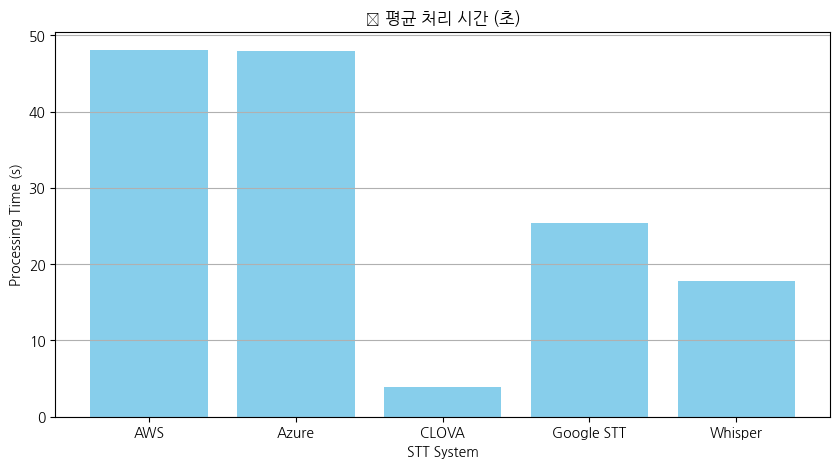

/Users/jeongminchoi/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Nanum Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


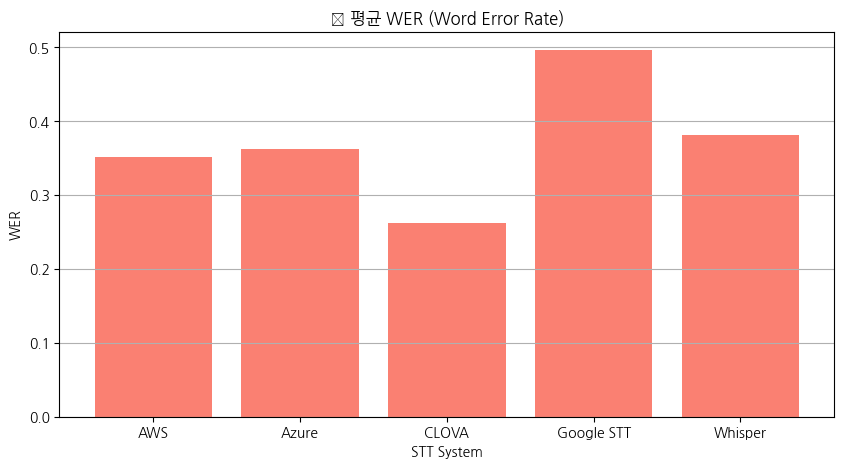

/Users/jeongminchoi/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Nanum Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


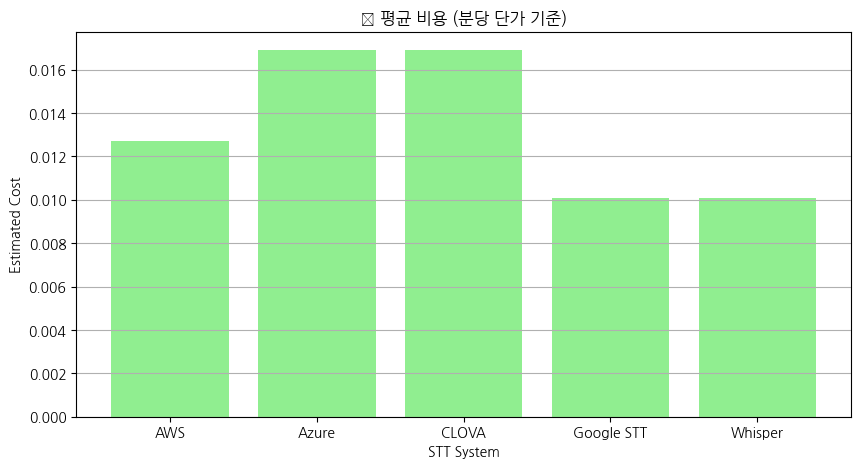

In [ ]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--audio',   required=True)
# parser.add_argument('--script',  required=True)
# parser.add_argument('--json',    required=True)
# parser.add_argument('--engines', nargs='+', required=True,
#                     choices=list(STT_FUNCTIONS.keys()))
# parser.add_argument('--workers', type=int, default=None)
# args = parser.parse_args()

# main_gpu(args.audio, args.script, args.json, args.engines, args.workers)

📋 STT 시스템별 WER / 처리 시간 / 비용 요약 (단위: %, 초, 원)


,STT_System,WER,Processing_Time_s,Cost_Estimate
0,AWS,0.3517,48.064,12.7
1,Azure,0.3614,47.930,16.9
2,CLOVA,0.2615,3.836,16.9
3,Google STT,0.4958,25.361,10.1
4,Whisper,0.3813,17.814,10.1


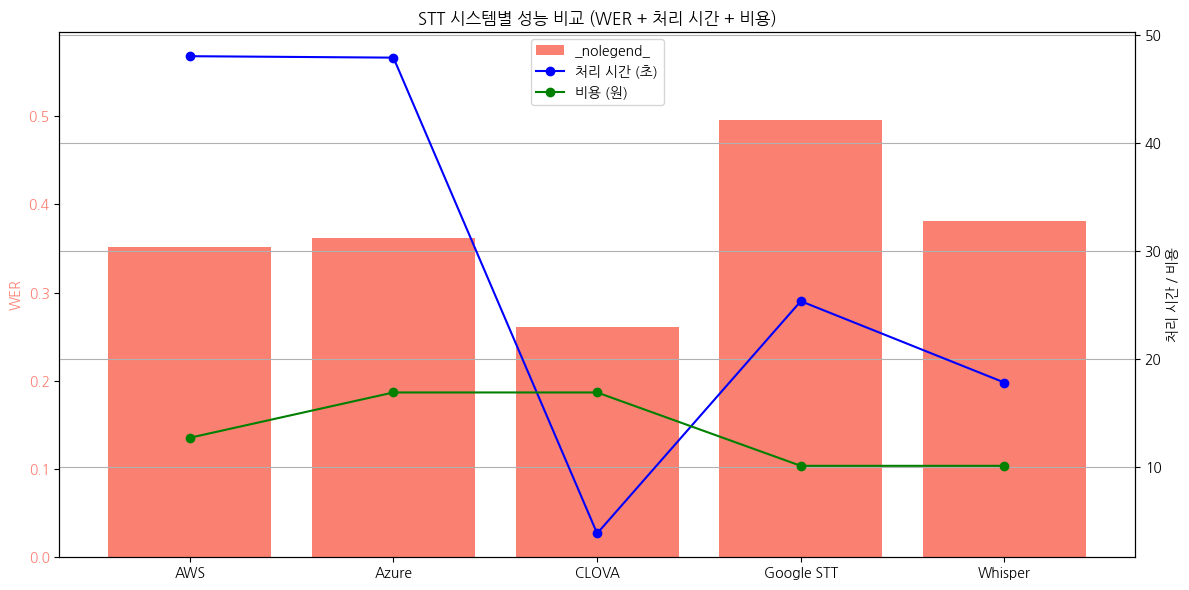

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from IPython.display import display

def plot_stt_summary_wer(summary_df):
    # ✅ 한글 폰트 자동 설정
    font_path = ""
    font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
    for font in font_list:
        if "NanumGothic" in font or "Malgun" in font:
            font_path = font
            break
    if font_path:
        font_name = fm.FontProperties(fname=font_path).get_name()
        plt.rcParams["font.family"] = font_name
        plt.rcParams["axes.unicode_minus"] = False

    # ✅ 비용 단위 정리
    summary_df = summary_df.copy()
    summary_df["WER"] = summary_df["WER"].round(4)
    summary_df["Cost_Estimate"] = (summary_df["Cost_Estimate"] * 1000).round(2)  # 원 단위

    # 📊 표 출력
    print("📋 STT 시스템별 WER / 처리 시간 / 비용 요약 (단위: %, 초, 원)")
    display(summary_df[["STT_System", "WER", "Processing_Time_s", "Cost_Estimate"]])

    # 🎨 시각화
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # WER (막대)
    bar_container = ax1.bar(summary_df["STT_System"], summary_df["WER"],
                            color="salmon", label="WER")
    ax1.set_ylabel("WER", color="salmon")
    ax1.tick_params(axis='y', labelcolor="salmon")
    ax1.set_ylim(0, max(summary_df["WER"]) * 1.2)

    # 처리 시간/비용 (선)
    ax2 = ax1.twinx()
    line1 = ax2.plot(summary_df["STT_System"], summary_df["Processing_Time_s"],
                     color="blue", marker="o", label="처리 시간 (초)")
    line2 = ax2.plot(summary_df["STT_System"], summary_df["Cost_Estimate"],
                     color="green", marker="o", label="비용 (원)")  # ✅ 초록색으로 변경
    ax2.set_ylabel("처리 시간 / 비용", color="black")
    ax2.tick_params(axis='y')

    # 범례 병합
    lines = [bar_container[0]] + line1 + line2
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper center")

    plt.title("STT 시스템별 성능 비교 (WER + 처리 시간 + 비용)")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

summary_df = df_results.groupby("STT_System").agg({
    "Processing_Time_s": "mean",
    "WER": "mean",
    "Cost_Estimate": "mean"
}).reset_index().round(4)

plot_stt_summary_wer(summary_df)


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from jiwer import cer

def run_stt_cer_evaluation(youtube_ids, answer_dir="./script", script_dir="./sttScript"):
    results = []

    for i, youtube_id in enumerate(youtube_ids, start=1):
        basename = f"audio{i}"

        # 정답 로드
        answer_path = os.path.join(answer_dir, f"{basename}.txt")
        if not os.path.isfile(answer_path):
            print(f"❌ 정답 없음: {answer_path}")
            continue
        with open(answer_path, "r", encoding="utf-8") as f:
            ground_truth = f.read().strip()

        # STT 시스템들에 대해 CER 계산
        system_names = ["clova", "whisper", "google stt", "azure", "aws"]
        for name in system_names:
            try:
                script_path = os.path.join(script_dir, f"{basename}_{name}.txt")
                if not os.path.isfile(script_path):
                    print(f"⚠️ 전사문 없음: {script_path}")
                    continue
                with open(script_path, "r", encoding="utf-8") as f:
                    predicted = f.read().strip()

                cer_score = cer(ground_truth, predicted)
                results.append({
                    "audio": basename,
                    "STT_System": name.upper(),
                    "CER": round(cer_score, 4),
                    "Character Accuracy": round(1 - cer_score, 4)
                })

            except Exception as e:
                print(f"❌ 오류: {name} - {e}")
                results.append({
                    "audio": basename,
                    "STT_System": name.upper(),
                    "CER": -1,
                    "Character Accuracy": 0,
                    "Error": str(e)
                })

    df = pd.DataFrame(results)
    df.to_csv("stt_cer_evaluation.csv", index=False, encoding="utf-8-sig")
    print("✅ 평가 결과 저장 완료: stt_cer_evaluation.csv")

    # 평균 요약 시각화
    summary = df.groupby("STT_System").agg({"CER": "mean"}).reset_index()
    plt.figure(figsize=(8, 4))
    plt.bar(summary["STT_System"], summary["CER"], color="cornflowerblue")
    plt.title("📉 평균 CER (Character Error Rate)")
    plt.ylabel("CER")
    plt.xlabel("STT System")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

    return df


In [ ]:
run_stt_cer_evaluation([1,2,3,4,5,6,7,8,9,10])

In [ ]:
import pandas as pd

# CSV 파일 불러오기
df = pd.read_csv("stt_cer_evaluation.csv")

# CER 평균 계산
cer_means = df.groupby("STT_System")["CER"].mean().round(4)

# 출력
print("📊 STT 시스템별 평균 CER:")
print(cer_means)
